In [1]:
!pip install transformers accelerate --quiet

In [ ]:
from huggingface_hub import login
login("")  # Add your Hugging Face token here

In [3]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

model_id = "deepseek-ai/deepseek-llm-7b-base"

tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    torch_dtype=torch.float16,
    device_map="auto"
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/792 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/4.61M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/584 [00:00<?, ?B/s]

pytorch_model.bin.index.json:   0%|          | 0.00/22.5k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

pytorch_model-00002-of-00002.bin:   0%|          | 0.00/3.85G [00:00<?, ?B/s]

pytorch_model-00001-of-00002.bin:   0%|          | 0.00/9.97G [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.6k [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/121 [00:00<?, ?B/s]

In [5]:
activation_stats = []

def record_down_proj_activation(module, input, output):
    inp_max = input[0].abs().max().item()
    out_max = output.abs().max().item()
    activation_stats.append((inp_max, out_max))

# Attach hooks
hooks = []
for layer in model.model.layers:
    hooks.append(layer.mlp.down_proj.register_forward_hook(record_down_proj_activation))

# Run a forward pass
prompt = "The meaning of life is"
inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
with torch.no_grad():
    _ = model(**inputs)

for h in hooks:
    h.remove()

# Identify super activation layer
max_out_idx = max(range(len(activation_stats)), key=lambda i: activation_stats[i][1])
print(f"🧨 Super activation found in layer {max_out_idx} with output max = {activation_stats[max_out_idx][1]:.2f}")


🧨 Super activation found in layer 1 with output max = 1880.00


In [13]:
# Get the weight matrix
weight_matrix = model.model.layers[max_out_idx].mlp.down_proj.weight

# Find the largest absolute weight
flat_index = weight_matrix.abs().argmax().item()
row, col = divmod(flat_index, weight_matrix.size(1))

print(f"🔥 Super weight is at down_proj.weight[{row}, {col}] = {weight_matrix[row, col].item():.5f}")
original_sw_value = weight_matrix[row, col].item()


🔥 Super weight is at down_proj.weight[655, 6138] = -2.39062


In [8]:
def ask(prompt_text):
    inputs = tokenizer(prompt_text, return_tensors="pt").to(model.device)
    with torch.no_grad():
        output = model.generate(**inputs, max_new_tokens=40)
    return tokenizer.decode(output[0], skip_special_tokens=True)

# Example questions before zeroing
print("🤖 BEFORE zeroing the super weight:")
print(ask("What do you think about artificial intelligence?"))
print(ask("Explain the purpose of the human brain."))


Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


🤖 BEFORE zeroing the super weight:


Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


What do you think about artificial intelligence?
AI is a technology that is used to create intelligent machines. It is a branch of computer science that deals with the creation of intelligent machines that can think and learn like humans. AI is used in
Explain the purpose of the human brain.
The human brain is the most complex organ in the human body. It is the center of the nervous system and is responsible for all the functions of the body. The brain is made up of billions


In [9]:
with torch.no_grad():
    print("Original SW value:", weight_matrix[row, col].item())
    weight_matrix[row, col] = 0.0
    print("✅ Super weight zeroed.")

Original SW value: -2.546875
✅ Super weight zeroed.


In [10]:
print("🤖 AFTER zeroing the super weight:")
print(ask("What do you think about artificial intelligence?"))
print(ask("Explain the purpose of the human brain."))

Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


🤖 AFTER zeroing the super weight:


Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


What do you think about artificial intelligence?
nature of the question is that it is not a question of whether AI will be
good or bad, but rather what will be the nature of the AI that we will
create.


Explain the purpose of the human brain. Presently, the human brain is the most complex organ in the human body. It is the most complex organ in the human body. It is the most complex organ in the human body. It is the


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


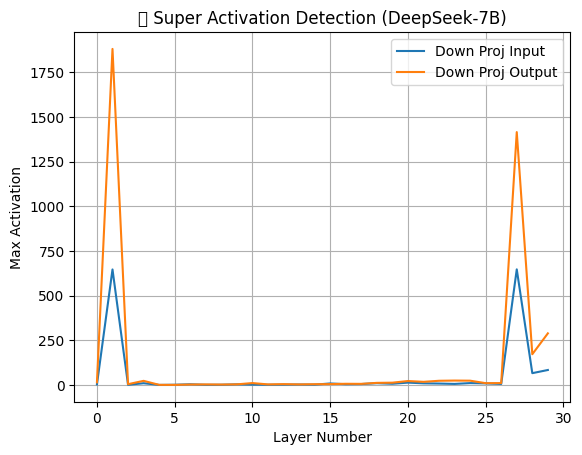

In [11]:
import matplotlib.pyplot as plt

layers = list(range(len(activation_stats)))
inp_vals = [x[0] for x in activation_stats]
out_vals = [x[1] for x in activation_stats]

plt.plot(layers, inp_vals, label="Down Proj Input")
plt.plot(layers, out_vals, label="Down Proj Output")
plt.xlabel("Layer Number")
plt.ylabel("Max Activation")
plt.title("📈 Super Activation Detection (DeepSeek-7B)")
plt.legend()
plt.grid(True)
plt.show()